<a href="https://colab.research.google.com/github/Ankur7470/nlp-assignment2/blob/main/Copy_of_NLP_assgn2_task2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

In [ ]:
!pip install nltk

## Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## EDA

### Loading the Sentiment Analysis Dataset

In [ ]:
sentiment_data = pd.read_csv("sentimentdataset.csv")

### Information about the Dataset

In [ ]:
sentiment_data.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [ ]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [ ]:
sentiment_data = sentiment_data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour'])

### Working with Sentiment Labels

In [ ]:
print("\nNo. of Unique Sentiments:", sentiment_data['Sentiment'].nunique())


No. of Unique Sentiments: 279


In [ ]:
sentiment_data['Sentiment'].unique()

array([' Positive  ', ' Negative  ', ' Neutral   ', ' Anger        ',
       ' Fear         ', ' Sadness      ', ' Disgust      ',
       ' Happiness    ', ' Joy          ', ' Love         ',
       ' Amusement    ', ' Enjoyment    ', ' Admiration   ',
       ' Affection    ', ' Awe          ', ' Disappointed ',
       ' Surprise     ', ' Acceptance   ', ' Adoration    ',
       ' Anticipation ', ' Bitter       ', ' Calmness     ',
       ' Confusion    ', ' Excitement   ', ' Kind         ',
       ' Pride        ', ' Shame        ', ' Confusion ', ' Excitement ',
       ' Shame ', ' Elation       ', ' Euphoria      ', ' Contentment   ',
       ' Serenity      ', ' Gratitude     ', ' Hope          ',
       ' Empowerment   ', ' Compassion    ', ' Tenderness    ',
       ' Arousal       ', ' Enthusiasm    ', ' Fulfillment  ',
       ' Reverence     ', ' Compassion', ' Fulfillment   ', ' Reverence ',
       ' Elation   ', ' Despair         ', ' Grief           ',
       ' Loneliness     

In [ ]:
# Stripping the leading and trailing spaces from each sentiment
sentiment_data['Sentiment'] = [sentiment.strip() for sentiment in sentiment_data['Sentiment']]

In [ ]:
print("\nNo. of Unique Sentiments after stripping the unwanted spaces from sentiment labels :", sentiment_data['Sentiment'].nunique())


No. of Unique Sentiments after stripping the unwanted spaces from sentiment labels : 191


In [ ]:
sentiment_counts = sentiment_data['Sentiment'].value_counts()
print("Sentiment Counts:\n")
sentiment_counts[:10]

Sentiment Counts:



,count
Sentiment,
Positive,45
Joy,44
Excitement,37
Contentment,19
Neutral,18
Gratitude,18
Curiosity,16
Serenity,15
Happy,14


### Checking for Duplicate Text Entries

In [ ]:
print("No. of Duplicate Text Entries", sentiment_data['Text'].duplicated().sum())

No. of Duplicate Text Entries 25


In [ ]:
# Filtering texts that appear more than once
duplicate_texts = sentiment_data.groupby('Text').size().reset_index(name='count')
duplicate_texts[duplicate_texts['count'] > 1]

,Text,count
1,"A compassionate rain, tears of empathy fallin...",3
4,"A free spirit soaring on the wings of dreams,...",2
12,"A playful escapade in the carnival of life, c...",3
40,"Bathed in the golden hues of gratefulness, a ...",2
52,Charting a course through the waves of hopefu...,2
59,"Confident strides in the dance of life, a bal...",2
81,"Dismissive gestures, a curtain drawn to shiel...",2
93,"Embraced by the hopeful dawn, a gardener sowi...",3
148,"Floating on clouds of inspiration, an artist ...",2
176,"Hopeful whispers of wind, carrying the promis...",2


### Handling Duplicate Text Entries

In [ ]:
# Keeping the first occurrence of each duplicate
sentiment_data = sentiment_data.drop_duplicates(subset=['Text'], keep='first')

In [ ]:
print("No. of Duplicate Text Entries (keeping only the first occurrence): ", sentiment_data['Text'].duplicated().sum())

No. of Duplicate Text Entries (keeping only the first occurrence):  0


In [ ]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 0 to 731
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       707 non-null    object
 1   Sentiment  707 non-null    object
dtypes: object(2)
memory usage: 16.6+ KB


## Data Preprocessing

### Applying Preprocessing to all the texts

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

sentiment_data['Tokenized Text'] = [preprocess_text(text) for text in sentiment_data['Text'].values]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Dataset after Preprocessing/Tokenization of texts

In [ ]:
sentiment_data.head(10)

,Text,Sentiment,Tokenized Text
0,Enjoying a beautiful day at the park! ...,Positive,"[enjoying, beautiful, day, park]"
1,Traffic was terrible this morning. ...,Negative,"[traffic, terrible, morning]"
2,Just finished an amazing workout! 💪 ...,Positive,"[finished, amazing, workout]"
3,Excited about the upcoming weekend getaway! ...,Positive,"[excited, upcoming, weekend, getaway]"
4,Trying out a new recipe for dinner tonight. ...,Neutral,"[trying, new, recipe, dinner, tonight]"
5,Feeling grateful for the little things in lif...,Positive,"[feeling, grateful, little, thing, life]"
6,Rainy days call for cozy blankets and hot coc...,Positive,"[rainy, day, call, cozy, blanket, hot, cocoa]"
7,The new movie release is a must-watch! ...,Positive,"[new, movie, release, mustwatch]"
8,Political discussions heating up on the timel...,Negative,"[political, discussion, heating, timeline]"
9,Missing summer vibes and beach days. ...,Neutral,"[missing, summer, vibe, beach, day]"


### Handling the High No. of Sentiments

In [ ]:
positive = {
    "Acceptance", "Accomplishment", "Admiration", "Adoration", "Affection", "Amazement",
    "Appreciation", "Blessed", "Breakthrough", "Calmness", "Celebration", "Charm",
    "Compassion", "Confidence", "Contentment", "Creativity", "Curiosity", "Dazzle",
    "Determination", "Ecstasy", "Elation", "Elegance", "Empowerment", "Enchantment",
    "Engagement", "Enjoyment", "Enthusiasm", "Euphoria", "Excitement", "FestiveJoy",
    "Freedom", "Friendship", "Fulfillment", "Grateful", "Gratitude", "Happiness",
    "Happy", "Harmony", "Heartwarming", "Hope", "Hopeful", "Inspiration", "Inspired",
    "Joy", "Kindness", "Love", "Marvel", "Motivation", "Optimism", "Overjoyed",
    "Playful", "Positivity", "Pride", "Proud", "Radiance", "Rejuvenation", "Relief",
    "Resilience", "Romance", "Satisfaction", "Serenity", "Success", "Thrill",
    "Tranquility", "Triumph", "Vibrancy", "Wonder", "Wonderment", "Positive", "Amusement",
    "Awe", "Compassionate", "JoyfulReunion", "Colorful", "PlayfulJoy", "Confident",
    "Celestial Wonder", "Spark",  "Thrilling Journey", "Whimsy", "Touched",
    "Adrenaline", "Exploration", "Hypnotic", "Energy", "Tenderness",
    "Free-spirited", "Grandeur", "Zest", "Kind",
    "Adventure"
}

negative = {
    "Anger", "Anxiety", "Bad", "Betrayal", "Bitter", "Bitterness", "Bittersweet",
    "Darkness", "Desolation", "Despair", "Desperation", "Devastated", "Disappointed",
    "Disappointment", "Disgust", "Frustration", "Grief", "Hate", "Heartache",
    "Heartbreak", "Helplessness", "Intimidation", "Isolation", "Jealous", "Jealousy",
    "Loneliness", "Loss", "LostLove", "Melancholy",  "Numbness",
    "Overwhelmed", "Regret", "Resentment", "Ruins", "Sad", "Sadness", "Shame", "Sorrow",
    "Suffering",  "Sympathy",  "Fear", "Fearful", "Negative",
    "Mischievous", "Embarrassed", "Envy", "Envious", "Dismissive", "Frustrated",
    "Apprehensive", "Pensive", "Exhaustion", "Indifference", "Confusion", "Solace", "Suspense","Yearning"
}

neutral = {
    "Ambivalence", "Anticipation", "Arousal", "ArtisticBurst", "Boredom","Miscalculation",
    "Captivation", "Challenge", "Connection", "Contemplation", "Coziness",
    "Creative Inspiration", "Culinary Adventure", "CulinaryOdyssey", "Emotion",
    "EmotionalStorm", "Empathetic", "Envisioning History", "Iconic", "Immersion",
    "InnerJourney", "Journey", "Melodic", "Mesmerizing", "Mindfulness",
    "Nature's Beauty", "Neutral", "Nostalgia", "Obstacle", "Ocean's Freedom",
    "Pressure", "Reflection", "Renewed Effort", "Reverence", "Runway Creativity",
    "Serenity", "Solitude", "Surprise", "Whispers of the Past", "Winter Magic",
    "Intrigue", "DreamChaser", "Joy in Baking","Imagination"
}

In [ ]:
def classify_sentiment(sentiment):
    if sentiment in positive:
        return 'Positive'
    elif sentiment in neutral:
        return 'Neutral'
    elif sentiment in negative:
        return 'Negative'
    else:
        return 'Neutral'

sentiment_data['Category'] = sentiment_data['Sentiment'].apply(classify_sentiment)

print(sentiment_data['Category'].value_counts())

Category
Positive    412
Negative    197
Neutral      98
Name: count, dtype: int64


### Encoding the sentiment labels

In [ ]:
le = LabelEncoder()
sentiment_data['Category'] = le.fit_transform(sentiment_data['Category'])

print("\nFinal Sentiment Labels:", le.classes_)


Final Sentiment Labels: ['Negative' 'Neutral' 'Positive']


In [ ]:
sentiment_data.head()

,Text,Sentiment,Tokenized Text,Category
0,Enjoying a beautiful day at the park! ...,Positive,"[enjoying, beautiful, day, park]",2
1,Traffic was terrible this morning. ...,Negative,"[traffic, terrible, morning]",0
2,Just finished an amazing workout! 💪 ...,Positive,"[finished, amazing, workout]",2
3,Excited about the upcoming weekend getaway! ...,Positive,"[excited, upcoming, weekend, getaway]",2
4,Trying out a new recipe for dinner tonight. ...,Neutral,"[trying, new, recipe, dinner, tonight]",1


### Extracting the Relevant Columns

In [ ]:
tokenized_texts = sentiment_data['Tokenized Text'].values
labels = sentiment_data['Category'].values

### Word2Vec Training & Text Vectorization

In [ ]:
def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Load GloVe embeddings
glove_path = 'glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

In [ ]:
# sample word vector
glove_embeddings['dream']

array([ 0.0030412,  0.45059  , -0.013381 ,  0.30563  ,  0.30148  ,
        0.11267  , -0.077003 ,  0.010461 ,  0.13649  , -0.21676  ,
        0.36484  , -0.40437  ,  0.032525 , -0.10075  , -0.19172  ,
       -0.32998  ,  0.56334  , -0.4174   , -0.19091  ,  0.60844  ,
        0.17271  ,  0.84758  , -0.029364 ,  0.77872  ,  0.12008  ,
        0.12991  ,  0.007814 , -0.099057 ,  0.11568  , -0.27244  ,
        0.026542 , -0.10197  , -0.48885  , -0.034344 , -1.158    ,
        0.47427  , -0.60191  ,  0.18971  ,  0.17906  ,  0.41396  ,
        0.012056 , -0.46989  ,  0.22853  ,  0.040757 ,  0.015289 ,
       -0.088703 ,  0.13041  ,  0.61631  ,  0.015202 , -0.41673  ,
        0.32114  ,  0.26846  ,  0.29011  ,  0.42869  , -0.23034  ,
        0.41543  ,  0.1959   , -0.012711 ,  0.38308  ,  0.41969  ,
       -0.28761  , -0.098217 ,  0.016179 ,  0.25311  ,  0.25486  ,
        0.33475  , -0.26802  ,  0.16306  ,  0.23669  , -0.063513 ,
        0.10962  , -0.17884  , -0.28927  ,  0.34737  , -0.0478

#### Converting the Tokenized texts into Sentence vectors

In [ ]:
# using average of word vectors to represent sentences.
def text_to_vectors(text, model, vector_size=300):
    vectors = [model[word] for word in text if word in model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Average word vectors
    else:
        return np.zeros(vector_size)  # Return zero vector if no words are in vocabulary

In [ ]:
vectorized_texts = np.array([text_to_vectors(text,glove_embeddings) for text in tokenized_texts])

In [ ]:
print("First Sentence in Tokenized form:\n", tokenized_texts[0])
print("\nFirst Sentence in Vectorized form:\n", vectorized_texts[0])  # Printing the first 5 word vectors from the first sentence

First Sentence in Tokenized form:
 ['enjoying', 'beautiful', 'day', 'park']

First Sentence in Vectorized form:
 [-4.77327518e-02 -1.02187499e-01 -1.40727490e-01 -4.17125132e-03
 -1.61682501e-01  1.66402251e-01  4.93877530e-02  1.64960008e-02
 -4.81030010e-02 -8.16160023e-01  2.90454239e-01 -1.20724000e-01
 -1.10280000e-01  3.21789980e-01 -2.21948251e-01 -1.26615494e-01
  2.89582498e-02 -1.28355790e-02  1.64037496e-01  1.60964996e-01
 -1.90183252e-01  3.56448919e-01 -8.13696533e-02  3.10008258e-01
  4.46002483e-02 -1.74820274e-02 -1.22214243e-01 -1.66362762e-01
 -1.01076499e-01  1.27534986e-01  3.78870010e-01  2.06534997e-01
 -3.20087492e-01  8.27795044e-02 -9.02437449e-01  3.23907256e-01
 -1.51585996e-01 -4.74044979e-02 -2.92210758e-01 -1.53154746e-01
  8.08372498e-02  2.63773650e-02  9.04249959e-03  3.06530982e-01
  6.43942505e-02 -8.02260041e-02  7.19457507e-01  3.34172517e-01
  3.72397512e-01 -5.65100014e-02 -3.46577764e-01 -2.46124998e-01
  1.45464987e-01  6.31750375e-03 -5.602500

### Preparing Data for Training

In [ ]:
X = vectorized_texts
y = labels

In [ ]:
X

array([[-0.04773275, -0.1021875 , -0.14072749, ...,  0.10268499,
         0.01451725,  0.13346867],
       [-0.00575667, -0.35075167,  0.07374   , ...,  0.17433365,
        -0.01515   ,  0.16792   ],
       [ 0.04859833,  0.321659  , -0.10786366, ..., -0.26571   ,
         0.13657533, -0.19160634],
       ...,
       [-0.12588866, -0.133423  ,  0.06993433, ..., -0.0935578 ,
        -0.00398653, -0.08727863],
       [ 0.09878233, -0.10901621,  0.16069223, ...,  0.19692151,
        -0.09322271, -0.26492453],
       [-0.1472001 ,  0.23215434,  0.03909946, ...,  0.06753419,
        -0.11467081,  0.03048269]], dtype=float32)

In [ ]:
y

array([2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1,
       2, 2, 1, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       0, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0,
       0, 1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Model Training and Evaluation

### Training the Model

In [ ]:
# Hyperparameters
input_size = X.shape[1]
output_size = len(le.classes_)
learning_rate = 0.001
batch_size = 32
epochs = 100

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features=300, h1=256, h2=128, h3=64, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.fc3 = nn.Linear(h2, h3)
        self.bn3 = nn.BatchNorm1d(h3)
        self.out = nn.Linear(h3, out_features)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.out(x)
        return x


In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store loss & accuracy trends
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\n Training Fold {fold+1}/{n_splits}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_dataset = SentimentDataset(X_train, y_train)
    test_dataset = SentimentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize Model, Optimizer, and Loss Function
    model = Model(in_features=input_size, h1=256, h2=128, h3=64, out_features=output_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

    # Early Stopping Parameters
    best_val_loss = float('inf')
    patience = 5
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        scheduler.step()

        # Compute Train Loss & Accuracy
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = (correct_train / total_train)*100
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val, total_val = 0, 0
        val_loss = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = (correct_val / total_val)*100
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/50] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping!")
            break



 Training Fold 1/5
Epoch [1/50] - Train Loss: 1.0636 | Val Loss: 1.0166 | Train Acc: 42.8319 | Val Acc: 58.4507
Epoch [2/50] - Train Loss: 0.8157 | Val Loss: 0.8163 | Train Acc: 68.1416 | Val Acc: 78.1690
Epoch [3/50] - Train Loss: 0.6852 | Val Loss: 0.6479 | Train Acc: 75.3982 | Val Acc: 83.0986
Epoch [4/50] - Train Loss: 0.5936 | Val Loss: 0.5700 | Train Acc: 78.9381 | Val Acc: 83.0986
Epoch [5/50] - Train Loss: 0.5936 | Val Loss: 0.5424 | Train Acc: 80.7080 | Val Acc: 82.3944
Epoch [6/50] - Train Loss: 0.5504 | Val Loss: 0.5371 | Train Acc: 81.5929 | Val Acc: 82.3944
Epoch [7/50] - Train Loss: 0.5200 | Val Loss: 0.5215 | Train Acc: 82.8319 | Val Acc: 83.0986
Epoch [8/50] - Train Loss: 0.4535 | Val Loss: 0.5218 | Train Acc: 83.7168 | Val Acc: 83.0986
Epoch [9/50] - Train Loss: 0.4321 | Val Loss: 0.5243 | Train Acc: 84.2478 | Val Acc: 83.0986
Epoch [10/50] - Train Loss: 0.3796 | Val Loss: 0.5085 | Train Acc: 86.0177 | Val Acc: 81.6901
Epoch [11/50] - Train Loss: 0.3879 | Val Loss: 0.

### Loss and Accuracy Curve During Training

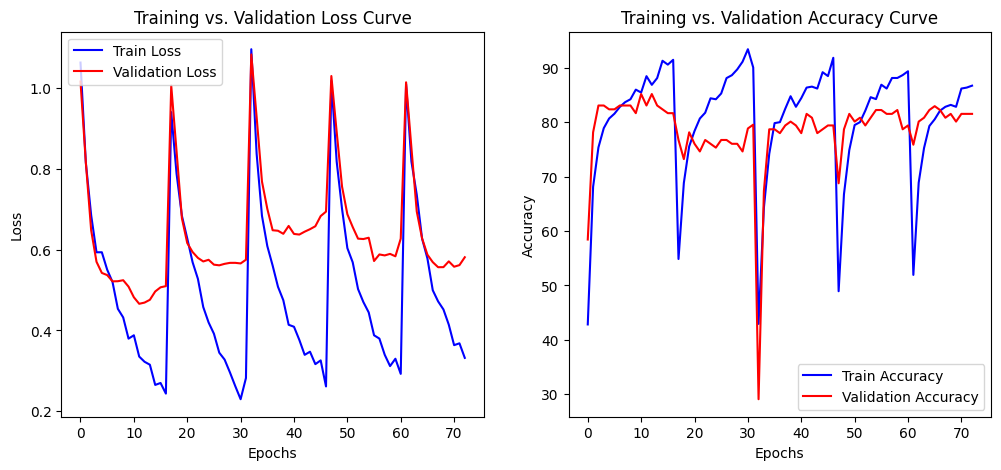

In [ ]:
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss Curve")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color='blue')
plt.plot(val_accuracies, label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy Curve")
plt.legend()

plt.show()

In [ ]:
final_val_accuracy = np.mean(val_accuracies)  # Take mean across all folds
print(f"\nFinal Validation Accuracy: {final_val_accuracy:.2f}%")



Final Validation Accuracy: 78.68%
